In [113]:
from run import Prepro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import tensorly as tl #tensorly package
from tensorly.decomposition import tucker #tucker decomp package
import utils_tensor as utils 

In [151]:
#load data 
#vision_data = np.load('data/vision_data_30_16_120_3years_test2.npy', allow_pickle = True)
vision_data = np.load('data/vision_data_50_20_60_3years_v2.npy', allow_pickle = True)
# vision_data = np.load('../../../Volumes/Samsung_T5/vision_data_50_20_90_1980_v3.npy', allow_pickle = True)
#y = np.load('data/y_30_16_120_3years_test2.npy', allow_pickle = True)
y = np.load('data/y_50_20_60_3years_v2.npy', allow_pickle = True) 
# y = np.load('../../../Volumes/Samsung_T5/y_50_20_90_1980_v3.npy', allow_pickle = True) 

In [152]:
print(vision_data.shape)
print(y.shape)

(83, 60, 3, 3, 25, 25)
(83, 60, 11)


In [220]:
class tensor_regression(torch.nn.Module):

    def __init__(self, x_stat, x_viz): 
        super(tensor_regression, self).__init__()
        v=1e-2 
        self.W1 = torch.nn.Parameter(torch.randn(x_stat.shape[1], x_stat.shape[2]) * v)
        self.W2 = torch.nn.Parameter(torch.randn(x_viz.shape[1], x_viz.shape[2], x_viz.shape[3], x_viz.shape[4]) * v)
        self.b = torch.nn.Parameter(torch.rand(1)) #scalar 
        

    def forward(self, x_stat, x_viz):
        'element-wise dot product + bias'
        #maybe this could be more elaborate, e.g. for each time step, do mapping, and then regress along time steps etc. 
        y1 = torch.einsum('nij,ij->n', x_stat, self.W1) #broadcast for each sample 
        y2 = torch.einsum('nijkl,ijkl->n',x_viz, self.W2)
        y_hat = y1+y2+self.b #bias term 
        
        return y_hat #vector of dim: n (sample size)

def loss_fn(y_hat, y):
    loss =  (y_hat - y).pow(2).sum() 
    return loss

In [221]:
#vision data reduce dims 
def viz_reduce(tensors, core_ranks): #input: tensors, sample_size = first dimension
    tensors = tensors.numpy()
    #low rank decomp
    core_out = np.zeros((tensors.shape[0], core_ranks[0], core_ranks[1], core_ranks[2], core_ranks[3]))
    approx_error = 0 
    for i in range(tensors.shape[0]):
        tensor = tensors[i]
        tensor = (tensor-np.amin(tensor)) / (np.amax(tensor)-np.amin(tensor)) #normalize 
        core, factors = tucker(tensor, core_ranks)
        core_out[i,:,:,:] = core 
        #calculate approximation error
        approx = utils.tucker_to_tensor(core, factors)
        approx_error +=  tl.norm(approx-tensor)/tl.norm(tensor)*100  #euclidean norm
    approx_error = approx_error/tensors.shape[0]
    
    core_out = torch.tensor(core_out).float()

    return core_out,  approx_error




In [222]:
#train nn 
def train_tensor_regression(y, x_stat, x_viz_compress, max_itr=4000, lr=1e-19):
    loss_arr =[] #record loss trajectory
    model = tensor_regression(x_stat_train, s_viz_train) 
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters())


    for t in range(max_itr):
        optimizer.zero_grad()
        y_hat= model(x_stat_train, s_viz_train)
        loss = loss_fn(y_hat, y_train)
        loss.backward()
        optimizer.step()

        #record loss and gradients 
        loss_arr.append(loss.detach().item())

    #plot loss 
    plt.plot(np.log(np.array(loss_arr)))
    print('final loss=', loss_arr[-1])
    return model 

In [ ]:
train_test_split = 0.8 #how much train test data
predict_at = 5 #steps_out
window_size = 8 #how many timesteps from the past to take ie steps_in

train_tensors, test_tensors = Prepro.process(vision_data, y, train_test_split, predict_at = predict_at, window_size=window_size)
x_viz_train, x_stat_train, tgt_intensity_cat_train, tgt_intensity_cat_baseline_train, tgt_displacement_train, tgt_intensity_train = train_tensors
x_viz_test, x_stat_test, tgt_intensity_cat_test, tgt_intensity_cat_baseline_test, tgt_displacement_test, tgt_intensity_test = test_tensors

print(vision_data.shape)
print(x_stat_train.shape)
print(x_viz_train.shape)

In [ ]:
core_ranks = [8,5,5,5]
s_viz_train, compression_error = viz_reduce(x_viz_train, core_ranks) #compress viz data 
print('compression_error=',compression_error)
s_viz_test, compression_error = viz_reduce(x_viz_test, core_ranks) #compress viz data 
print('compression_error=',compression_error)

final loss= 1453.5244140625
tensor_regression dx_mae 0.5257858
final loss= 1444.4901123046875
tensor_regression dy_mae 3.1421301


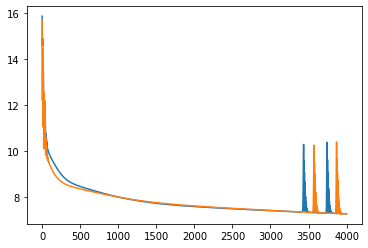

In [210]:
y_train = tgt_displacement_train[:,0]
model = train_tensor_regression(y_train, x_stat_train, s_viz_train,lr=1e-5)
y_hat = model(x_stat_test, s_viz_test)
y_true = tgt_displacement_test[:,0]
print("tensor_regression dx_mae", mean_absolute_error(y_true, y_hat.detach().numpy()))

y_train2 = tgt_displacement_train[:,1]
model = train_tensor_regression(y_train2, x_stat_train, s_viz_train,lr=1e-5)
y_hat2 = model(x_stat_test, s_viz_test)
y_true2= tgt_displacement_test[:,1]
print("tensor_regression dy_mae", mean_absolute_error(y_true2, y_hat2.detach().numpy()))


final loss= 1113.613037109375
accuracy score 0.6318114874815906
Baseline score 0.5949926362297496


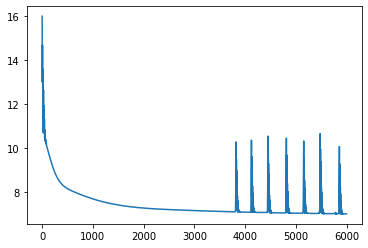

In [218]:
y_train = tgt_intensity_cat_train 
model = train_tensor_regression(y_train, x_stat_train, s_viz_train, max_itr=6000, lr=5e-5)
y_hat3 = model(x_stat_test, s_viz_test)
y_true = tgt_intensity_cat_test
print("accuracy score", accuracy_score(y_true, y_hat3.round().detach().numpy()))
print("Baseline score", accuracy_score(y_true, tgt_intensity_cat_baseline_test))